In [4]:
''' RNN Bidireccional en Keras '''
__author__ = '@Tssp'
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from codvidutils.Transformation_class import Transformation
import tensorflow as tf
from keras.layers import Conv2D, Input, Dense, MaxPooling2D, UpSampling2D, Flatten
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

In [5]:
trns = Transformation('data/train_split_v4.csv', 'data/test_split_v4.csv')
#------------Read images and prepare dataset------------#
train_class, test_class = trns.read_imgs_paths()
X_train, X_test, diseaseID_train, diseaseID_test = trns.read_imgs(train_class, test_class)
del train_class, test_class
#------------Imbalanced methods------------#
X_train, X_test, diseaseID_train = trns.underbalance(X_train, X_test, diseaseID_train)
print('X_train.shape: {}\nX_test.shape: {}'.format(X_train.shape, X_test.shape))
print("Normal train: ",diseaseID_train[diseaseID_train==0].shape)
print("Pneumonia train: ",diseaseID_train[diseaseID_train==2].shape)
print("COVID train: ",diseaseID_train[diseaseID_train==1].shape)
print("*******************************************************")
print("Normal test: ",diseaseID_test[diseaseID_test==0].shape)
print("Pneumonia test: ",diseaseID_test[diseaseID_test==2].shape)
print("COVID test: ",diseaseID_test[diseaseID_test==1].shape)
X_train, X_test, diseaseID_train, diseaseID_test = trns.new_imgs(X_train, X_test, diseaseID_train, diseaseID_test)
Y_train = np.copy(diseaseID_train)
del diseaseID_train
Y_train[Y_train==2]=0
Y_test = np.copy(diseaseID_test)
Y_test[Y_test==2]=0
X_test = X_test/255
X_train = X_train/255

You are going to read from: data/train_split_v4.csv and data/test_split_v4.csv
Total number of images: 1540
shape X: 13600 1540,  disease_ID (Y): 13600 1540
Count of classes:  Counter({0: 7966, 2: 5447, 1: 187})
New diseaseID shape:  (9097,)
New X shape:  (9097, 120000)
New Count of classes:  Counter({0: 4500, 2: 4500, 1: 97})
Undersample shapes:
diseaseID_train.shape: (9097,)
X_train.shape: (9097, 120000)
X_train.shape: (9097, 200, 200, 3)
X_test.shape: (1540, 200, 200, 3)
Normal train:  (4500,)
Pneumonia train:  (4500,)
COVID train:  (97,)
*******************************************************
Normal test:  (885,)
Pneumonia test:  (591,)
COVID test:  (64,)
(2425, 180, 180, 3)
(2425,)
X_train.shape:  (11522, 180, 180, 3)
diseaseID_train.shape:  (11522,)
X_test_news.shape:  (1600, 180, 180, 3)
diseaseID_test_news.shape:  (1600,)
X_test.shape:  (3140, 180, 180, 3)
diseaseID_test.shape:  (3140,)


## Neural network

In [44]:
input_img = Input(shape=X_train.shape[1:])
encoder = Conv2D(256, (3, 3), activation='relu', padding='same', name='Econv2d_1')(input_img)
encoder = MaxPooling2D((2,2), padding='same', name='Emaxpool2d_1')(encoder)
encoder = Conv2D(128, (3, 3), activation='relu', padding='same', name='Econv2d_2')(encoder)
encoder = MaxPooling2D((2,2), padding='same', name='Emaxpool2d_2')(encoder)
encoder = Conv2D(64, (3, 3), activation='relu', padding='same', name='Econv2d_3')(encoder)
encoder = MaxPooling2D((2,2), padding='same', name='Emaxpool2d_3')(encoder)

decoder = Conv2D(64, (3,3), activation='relu', padding='same', name='Dconv2d_1')(encoder)
decoder = UpSampling2D((2, 2), name='Dupsamp_1')(decoder)
decoder = Conv2D(128, (3, 3), activation='relu', padding='same', name='Dconv2d_2')(decoder)
decoder = UpSampling2D((2, 2), name='Dupsamp_2')(decoder)
decoder = Conv2D(256, (3, 3), activation='relu', name='Dconv2d_3')(decoder)
decoder = UpSampling2D((2, 2), name='Dupsamp_3')(decoder)
decoder = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='Dconv2d_out')(decoder)

autoencoder = Model(input_img, decoder)
autoencoder.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 180, 180, 3)       0         
_________________________________________________________________
Econv2d_1 (Conv2D)           (None, 180, 180, 256)     7168      
_________________________________________________________________
Emaxpool2d_1 (MaxPooling2D)  (None, 90, 90, 256)       0         
_________________________________________________________________
Econv2d_2 (Conv2D)           (None, 90, 90, 128)       295040    
_________________________________________________________________
Emaxpool2d_2 (MaxPooling2D)  (None, 45, 45, 128)       0         
_________________________________________________________________
Econv2d_3 (Conv2D)           (None, 45, 45, 64)        73792     
_________________________________________________________________
Emaxpool2d_3 (MaxPooling2D)  (None, 23, 23, 64)        0  

In [35]:
best_model_path = 'hdf_files/Autoencoder_covid_v5.hdf5'
checkpoint = ModelCheckpoint(best_model_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
amsgrad = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=True)
autoencoder.compile(optimizer=amsgrad, loss='mse', metrics=['acc', 'mse'])
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    history = autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, shuffle=False, callbacks=[checkpoint],
                              validation_data=(X_test, X_test))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Train on 11522 samples, validate on 3140 samples
Epoch 1/10
11522/11522 [==============================] - 94s 8ms/step - loss: 0.0130 - acc: 0.4484 - mse: 0.0130 - val_loss: 0.0038 - val_acc: 0.6541 - val_mse: 0.0038

Epoch 00001: loss improved from inf to 0.01297, saving model to hdf_files/Autoencoder_covid_v5.hdf5
Epoch 2/10
11522/11522 [==============================] - 94s 8ms/step - loss: 0.0022 - acc: 0.3675 - mse: 0.0022 - val_loss: 0.0019 - val_acc: 0.7156 - val_mse: 0.0019

Epoch 00002: loss improved from 0.01297 to 0.00221, saving model to hdf_files/Autoencoder_covid_v5.hdf5
Epoch 3/10
11522/11522 [==============================] - 93s 8ms/step - loss: 0.0018 - acc: 0.3674 - mse: 0.0018 - val_loss: 0.0018 - val_acc: 0.6458 - val_mse: 0.0018

Epoch 00003: loss improved from 0.00221 to 0.00184, saving model to hdf_files/Autoencode

In [36]:
best_model_path = 'hdf_files/Autoencoder_covid_v5.hdf5'
model = load_model(best_model_path)
encoder = Model(model.layers[0].input, model.layers[6].output)
encoder_imgs = encoder.predict(X_test)
decoder_imgs = model.predict(X_test)
encoder_imgs.shape

(3140, 23, 23, 64)

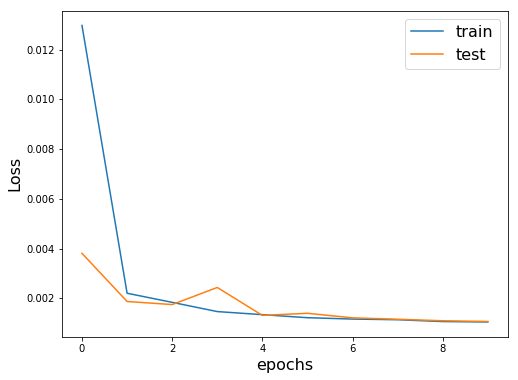

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='test')
ax.legend(fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
ax.set_xlabel('epochs', fontsize=16)
fig.savefig('Figures/Loss.png', dpi=200)

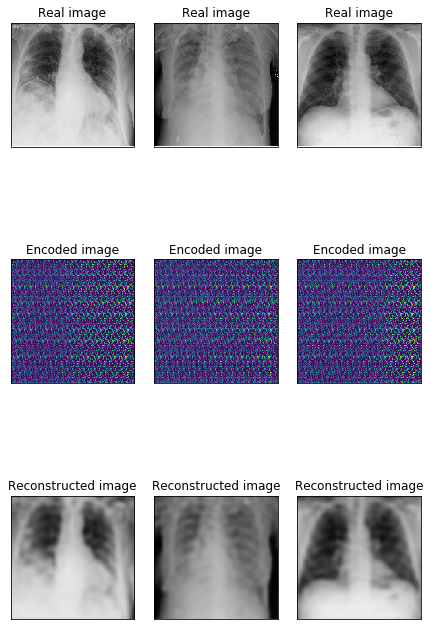

In [42]:
plt.figure(figsize=(20, 10))
for it in range(3):
    i = np.random.randint(0, len(encoder_imgs))
    ax = plt.subplot(3, 10, it+1)
    ax.imshow(X_test[i])
    plt.xticks(())
    plt.yticks(())
    ax.set_title('Real image')
    ax2 = plt.subplot(3, 10, it + 1 + 10)
    ax2.imshow(encoder_imgs[i].reshape(23*8, 23*8).T)
    plt.xticks(())
    plt.yticks(())
    ax2.set_title('Encoded image')
    ax3 = plt.subplot(3, 10, it + 1 + 2*10)
    ax3.imshow(decoder_imgs[i])
    plt.xticks(())
    plt.yticks(())
    ax3.set_title('Reconstructed image')
    plt.tight_layout()
    plt.savefig('Figures/Autoencoder_Reconstruction.png', dpi=200)